# Programming Assignment 4: Implementing Linear Classifiers

**Members:** Michael Hoon Yong Hau (yongm@chalmers.se), Chua Shan Hong (shanho@chalmers.se)

**PA4 Group 5**

# Task 1

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline

X1 = [{'city':'Gothenburg', 'month':'July'},
      {'city':'Gothenburg', 'month':'December'},
      {'city':'Paris', 'month':'July'},
      {'city':'Paris', 'month':'December'}]
Y1 = ['rain', 'rain', 'sun', 'rain']

X2 = [{'city':'Sydney', 'month':'July'},
      {'city':'Sydney', 'month':'December'},
      {'city':'Paris', 'month':'July'},
      {'city':'Paris', 'month':'December'}]
Y2 = ['rain', 'sun', 'sun', 'rain']

classifier1 = make_pipeline(DictVectorizer(), Perceptron(max_iter=10))
classifier1.fit(X1, Y1)
guesses1 = classifier1.predict(X1)
print(accuracy_score(Y1, guesses1))

classifier2 = make_pipeline(DictVectorizer(), Perceptron(max_iter=10))
# classifier2 = make_pipeline(DictVectorizer(), LinearSVC())
classifier2.fit(X2, Y2)
guesses2 = classifier2.predict(X2)
print(accuracy_score(Y2, guesses2))

1.0
0.5


In this problem, we are developing a simple system to predict the weather based on our location and the season. We can look at the problem intuitively since we only have 4 data points here.

 The code uses `DictVectorizer`, which one-hot encodes categorical features. So for each city and month, it creates binary features, where for `X1`, the features would be `city=Gothenburg`, `city=Paris`, `month=July`, `month=December` for example.

 Both the SVC and Perceptron models used are **linear models**, so they can only learn **linear** decision boundaries. For the model to *perfectly* classify the training data, the classes must be linearly separable in the feature space. If they are not, the perceptron can't find a separating hyperplane, even if we train it on the same data.

 The reason why the first dataset works is exactly because it is linearly separable in the feature space. The examples given here are:

1. Gothenburg, July → rain

2. Gothenburg, December → rain

3. Paris, July → sun

4. Paris, December → rain

We can see that for Gothenburg regardless of the month, it is raining, and for Paris, it's sun in July and rain in December. In the feature space, the samples are (correspondingly):

1. `[1, 0, 1, 0]` → rain

2. `[1, 0, 0, 1]` → rain

3. `[0, 1, 1, 0]` → sun

4. `[0, 1, 0, 1]` → rain

We can see that a linear model such as the Perceptron or the SVC can easily learn a rule like (`if city=Paris and month=July, predict "sun"; else "rain"`), so we can get an accuracy of 100% here with a linear decision boundary (separating hyperplane).

In the second dataset `X2` however, we have:

1. Sydney, July → rain

2. Sydney, December → sun

3. Paris, July → sun

4. Paris, December → rain

So the encoded features would be similar to before: `city=Sydney, city=Paris, month=July, month=December`, with the corresponding feature samples:

1. `[1, 0, 1, 0]` → rain

2. `[1, 0, 0, 1]` → sun

3. `[0, 1, 1, 0]` → sun

4. `[0, 1, 0, 1]` → rain

For both cities, the same city but different months have different weather, and the same months for different cities have different weather as well. We can see that the same combinations of features lead to different labels, so there's no single linear combination (linearly separable hyperplane) that can capture this. Thus, the data is clearly not linearly separable, and requires non-linear interactions to capture. The Perceptron and SVC thus fail on non-linearly separable data, regardless of training iterations.

If we want to properly capture this relation, we will need a model that is non-linear in nature such as a decision tree for example, or even come up with another feature such as `city_month` via feature engineering to capture this.

# Task 2: Preparation for Next Tasks

The package contains the perceptron code presented during one of the lectures (`aml_perceptron.py`). There is a `LinearClassifier` base class which provides shared functionality for all linear classifiers, such as computing the `decision_function()` (computes the dot product - linear combination of features and weights), `predict()` (Converts scores to class labels using a threshold of 0.0), `find_classes()` (identifies the two classes in dataset), and `encode_output()` (Maps class labels to positive and negative) functions. This is inherited by the by the `Perceptron` class which defines a basic perceptron algorithm.

Running the provided code `aml_perceptron.py` we get the following output:



```
Training time: 0.78 sec.
Accuracy: 0.7919
```

# Task 3: Implementing the SVC

Here we implement the Pegasos algorithm for training support vector classifiers by converting the pseudocode in Algorithm 1 in the clarification document.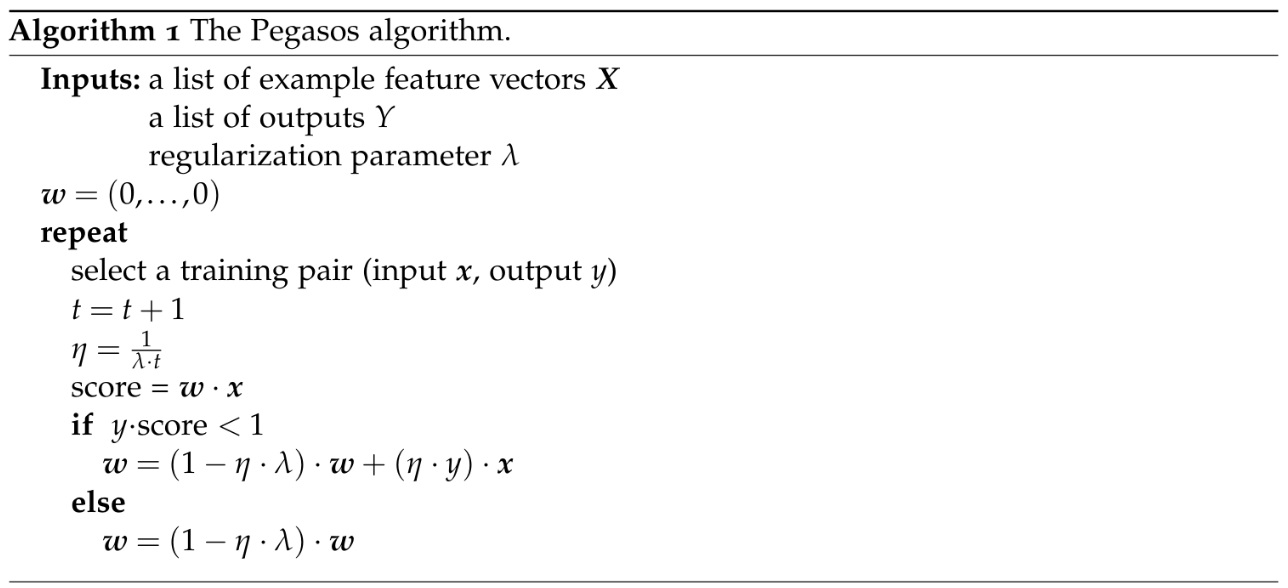

Below shows the completed algorithm in Python for the PegasosSVC classifier, which inherits from the LinearClassifier class. Following the pseudocode, we use the similar code as the Perceptron class, and set a new parameter `lambda_reg` corresponding to the regularisation parameter. We initialise a step counter `t`, and calculate the `eta` value at each epoch in the training phase, as well as the dot product score similar to the Perceptron. In the PegasosSVC class however, the update weight is now based on the hinge loss condition where `y ⋅ score < 1`, else it is simply the regularisation term.

In [ ]:
class PegasosSVC(LinearClassifier):
    """
    A straightforward implementation of the Pegasos algorithm for training linear SVM Classifiers.
    """

    def __init__(self, lambda_reg=0.001, n_iter=40):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.lambda_reg = lambda_reg

    def fit(self, X, Y):
        """
        Train a linear classifier using the Pergasos learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        n_examples = X.shape[0]
        self.w = np.zeros(n_features)

        t = 1

        # Perceptron algorithm:
        for epoch in range(self.n_iter):
            total_loss = 0.0
            # shuffle to similate random sampling
            idx = np.random.permutation(n_examples)
            X_shuffled, Ye_shuffled = X[idx], Ye[idx]

            for x, y in zip(X_shuffled, Ye_shuffled):
                # learning rate
                eta = 1.0 / (self.lambda_reg * t)

                # Compute the output score for this instance.
                score = np.dot(x, self.w)

                # hinge loss
                hinge_loss = max(0, 1 - y*score)
                total_loss += hinge_loss

                # pegasos update rule
                if y*score < 1:
                    # hinge loss + regularisation
                    self.w = (1-eta*self.lambda_reg)*self.w + eta*y*x
                else:
                    # regularisation
                    self.w = (1-eta*self.lambda_reg)*self.w
                t += 1

            mean_loss = total_loss / n_examples
            reg_term = 0.5 * self.lambda_reg * np.dot(self.w, self.w)
            objective = mean_loss + reg_term
            print(f"Epoch {epoch+1}/{self.n_iter}, Objective: {objective:.4f}")
            print(f"Mean Loss: {mean_loss:.4f}, Regularization Term: {reg_term:.4f}")

Here, we used a `lambda = 0.001` with `n_iter = 40` which gives us:


```
Training time: 2.77 sec.
Accuracy: 0.8246.
```

Based on manual testing, we found that these two hyperparameters gave the best accuracy and training time trade-off, with the value of lambda significantly affecting the final accuracy values. Beyond 100 iterations, we saw little variation in the accuracy (based on the calculated mean loss value by epoch) and this simply increased the training time with marginal benefit.

# Task 4: Logistic Regression

The logistic regression classifier is based on an objective function that looks almost like the one used by the SVC, however with a **log loss** instead of a hinge loss function. We use a similar class definition for the PegasosLR class as the PegasosSVC class earlier, and change the loss function to the log loss. The document gave the gradient of the log loss as

$\nabla (\text{Loss}) = - \frac{y_i}{1 + \exp{(y_i \cdot (\mathbf{w} \cdot \mathbf{x_i}}))} \cdot \mathbf{x_i}$

which we implement in the python code below:

In [ ]:
class PegasosLR(LinearClassifier):
    """
    A straightforward implementation of the Pegasos algorithm for training logistic regression classifiers.
    """

    def __init__(self, lambda_reg=0.001, n_iter=40):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.lambda_reg = lambda_reg

    def fit(self, X, Y):
        """
        Train a linear classifier using the Pergasos learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        n_examples = X.shape[0]
        self.w = np.zeros(n_features)

        t = 1

        # Perceptron algorithm:
        for epoch in range(self.n_iter):
            total_loss = 0.0
            # shuffle to similate random sampling
            idx = np.random.permutation(n_examples)
            X_shuffled, Ye_shuffled = X[idx], Ye[idx]

            for x, y in zip(X_shuffled, Ye_shuffled):
                # learning rate
                eta = 1.0 / (self.lambda_reg * t)

                # Compute the output score for this instance.
                score = np.dot(x, self.w)

                # log loss
                log_loss = np.log(1 + np.exp(-y*score))
                total_loss += log_loss

                # pegasoslr update rule
                exp = np.exp(y*score)
                grad = (y * x) / (1 + exp)

                # update weight
                self.w = (1-eta*self.lambda_reg)*self.w + eta*grad
                t += 1

            mean_loss = total_loss / n_examples
            reg_term = 0.5 * self.lambda_reg * np.dot(self.w, self.w)
            objective = mean_loss + reg_term
            print(f"Epoch {epoch+1}/{self.n_iter}, Objective: {objective:.4f}")
            print(f"Mean Loss: {mean_loss:.4f}, Regularization Term: {reg_term:.4f}")

This gives us the value of:

```
Training time: 4.02 sec.
Accuracy: 0.8074.
```

With the same parameters `lambda = 0.001`, and `n_iter=40`, based on the value of the mean loss stabilising.



Another difference here is that Logistic regression updates weights on **every** example (no if `y*score < 1` condition). Based on the epochs, mean loss/regularisation values, and the training time, we see that the Logistic Regression classifier is overall slower (probably due to the `np.exp()` calculations), but more stable in the training phase. Both achieve >80% accuracy values, however the logistic regression classifier performs slightly poorer with a value of 80.7%. SVM most like slightly better with high-dimensional sparse data compared to LR. LR is also better calibrated for probabilities.

For both classifiers, we also print approximate values of the SVM or LR objective function while training, together with the mean loss and regularisation term values. We see that for convergence, the LR classifier is smoother and more consistent decrease while the SVC tends to decrease sharply then plateau., consistent with the loss function graph shapes.